In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import seaborn as sns

#### Задание 1.1

Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

In [2]:
df = pd.read_csv('./data/ghana_gdp.csv', index_col='year', parse_dates=['year'])

In [3]:
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


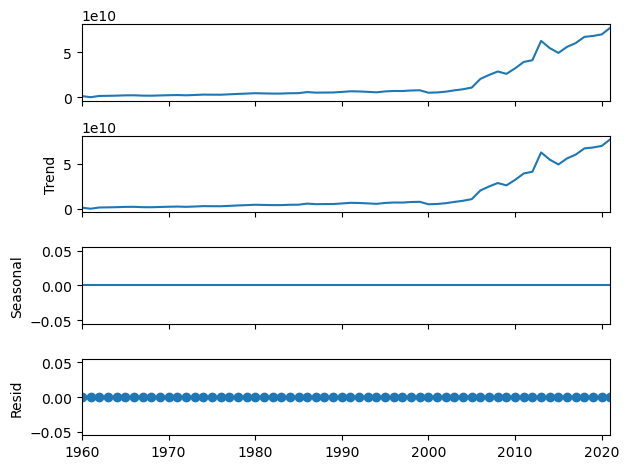

In [4]:
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()
plt.show()

Мы видим что тренд присутствует, сезонность отсутствует.

In [5]:
# делим данные на train и test

train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

#### Задание 1.2

Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод `rolling()`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

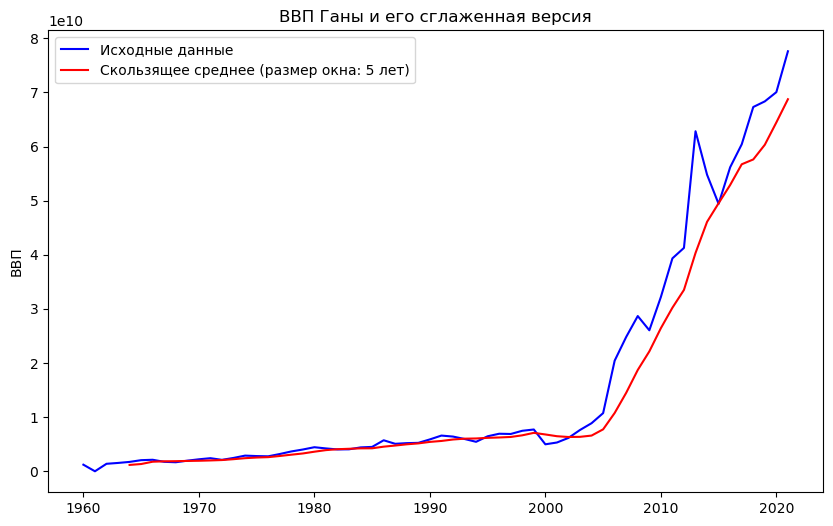

In [6]:
gpd_column_name = df.columns[0]
q = 5
rolling_mean = df[gpd_column_name].rolling(window=q).mean()

plt.figure(figsize=(10, 6))
plt.plot(df[gpd_column_name], label='Исходные данные', color='blue')
plt.plot(rolling_mean, label=f'Скользящее среднее (размер окна: {q} лет)', color='red')
plt.legend()
plt.title('ВВП Ганы и его сглаженная версия')
plt.xlabel('')
plt.ylabel('ВВП')
plt.show()


##### Вывод

На графике скользящего среднего четко виден тренд, плавно растущий до `2005` года, затем с `2006` начинается его резкий рост.

#### Задание 1.3

С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

Параметры `p` и `q` выберите по коррелограммам ACF и PACF.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным `p` и `q`, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).


In [7]:
def run_adfuller_on_data(df):
    result = adfuller(df.values)

    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")

    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")

run_adfuller_on_data(df)

ADF Statistic: 2.3738393561489173
p-value: 0.9989974617734
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593


Мы не можем отвергнуть нулевую гипотезу (о том что ряд нестационарен) поскольку полученное значение ADF Statistics больше всех трех критических значений. Это значит, что для прогноза нам понадобится модель ARIMA.

In [8]:
# Найдем порядок дифференциирования ряда.

df_diff_1 = df.diff().dropna()
run_adfuller_on_data(df_diff_1)

ADF Statistic: -1.5879441118004731
p-value: 0.4896467177743555
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


In [9]:
# порядок 1 не подходит, пробуем 2

df_diff_2 = df_diff_1.diff().dropna()
run_adfuller_on_data(df_diff_2)

ADF Statistic: -1.7459087628491348
p-value: 0.40762748326075415
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


In [10]:
# порядок 2 не подходит, пробуем 3

df_diff_3 = df_diff_2.diff().dropna()
run_adfuller_on_data(df_diff_3)

ADF Statistic: -5.278476343687432
p-value: 6.066691711556101e-06
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


Временный ряд имеет порядок дифференциирования `d=3`

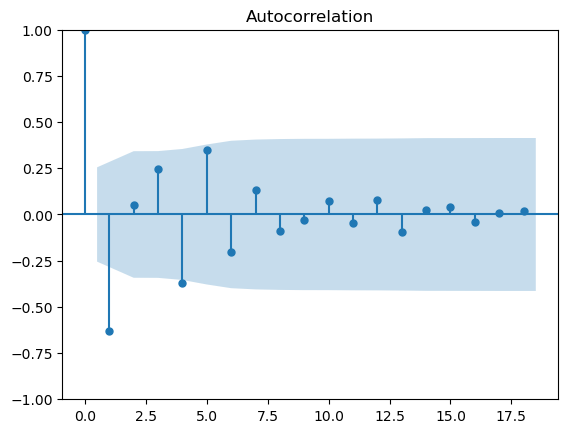

In [11]:
# Строим графики корреляции и автокорреляции,
# чтобы определить параметры `q` и `p`.

plot_acf(df_diff_3)
plt.show()

Возьмем `q=1`

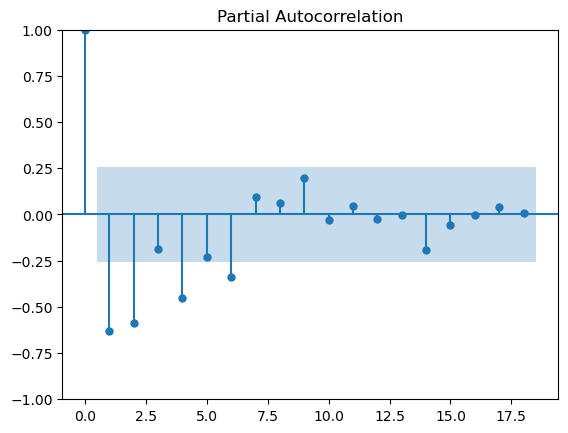

In [12]:
plot_pacf(df_diff_3)
plt.show()

Возьмем `p=2`

In [13]:
# Строим модель ARIMA

p = 2 # кол-во слагаемых AR (авторегрессии)
d = 3 # порядок дифференцирования
q = 1 # кол-во слагаемых MA (скользящего среднего)

arima_model = ARIMA(train_df, order=(p, d, q))
res = arima_model.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 18 Oct 2023   AIC                           2659.231
Time:                        21:00:20   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.0

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [14]:
# Попробуем построить еще несколько моделей с различными значениями p и q

p = 3
q = 2
arima_model = ARIMA(train_df, order=(p, d, q))
res = arima_model.fit()
print(res.summary())


                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(3, 3, 2)   Log Likelihood               -1325.504
Date:                Wed, 18 Oct 2023   AIC                           2663.008
Time:                        21:00:20   BIC                           2675.160
Sample:                    01-01-1960   HQIC                          2667.719
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5582      0.079    -19.774      0.000      -1.713      -1.404
ar.L2         -0.9965      0.163     -6.115      0.000      -1.316      -0.677
ar.L3         -0.2478      0.127     -1.954      0.0

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

In [15]:
p = 2
q = 2
arima_model = ARIMA(train_df, order=(p, d, q))
res = arima_model.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 2)   Log Likelihood               -1324.310
Date:                Wed, 18 Oct 2023   AIC                           2658.620
Time:                        21:00:20   BIC                           2668.747
Sample:                    01-01-1960   HQIC                          2662.547
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4012      0.031    -44.930      0.000      -1.462      -1.340
ar.L2         -0.6714      0.026    -25.379      0.000      -0.723      -0.620
ma.L1      -7.329e-07   2786.336  -2.63e-10      1.0

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Use

In [16]:
p = 3
q = 1
arima_model = ARIMA(train_df, order=(p, d, q))
res = arima_model.fit()
print(res.summary())

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(3, 3, 1)   Log Likelihood               -1325.396
Date:                Wed, 18 Oct 2023   AIC                           2660.791
Time:                        21:00:20   BIC                           2670.918
Sample:                    01-01-1960   HQIC                          2664.717
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8027      0.171     -4.690      0.000      -1.138      -0.467
ar.L2         -0.5505      0.290     -1.898      0.058      -1.119       0.018
ar.L3         -0.1255      0.174     -0.723      0.4

Наименьшее значение `AIC=2658` достигается при `p=2` и `q=2`

In [17]:
# Попробуем сделать то же самое с помощью pmdarima,
# но расширим диапазон значений еще немного

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=3,
    start_q=1,
    max_p=3,
    max_q=3,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.00 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.02 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.02 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.02 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.362 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Wed, 18 Oct 2023   AIC                           2659.231
Time:                        21:00:20   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.99e+56. Standard errors may be unstable.
"""

Алгоритм предлагает нам взять те же значения, с которых мы начинали — `p=2`, `q=1` — несмотря на то, что для них критерий AIC немного больше, чем для `p=2`, `q=2`. Видимо `pmdarima` ориентируется не только на этот критерий.

#### Задание 1.4

Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).

In [18]:
p = 2
d = 3
q = 1

arima_model = ARIMA(train_df, order=(p, d, q)).fit()

start = start=test_df.index[0]
end = test_df.index[-1]
test_pred = arima_model.predict(start=start, end=end, dynamic=False)

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [19]:
test_pred.values

array([7.36859124e+10, 7.95456653e+10, 8.63393562e+10])

In [20]:
test_df['pred'] = test_pred

/var/folders/y4/26v6lgdd66340v06vrs_07sr0000gn/T/ipykernel_91986/4025010039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = test_pred


In [21]:
test_df

,GDP (current US$),pred
year,,
2019-01-01,6.833754e+10,7.368591e+10
2020-01-01,7.004320e+10,7.954567e+10
2021-01-01,7.759428e+10,8.633936e+10


#### Задание 1.5

Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

In [22]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = arima_model.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

forecast = arima_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

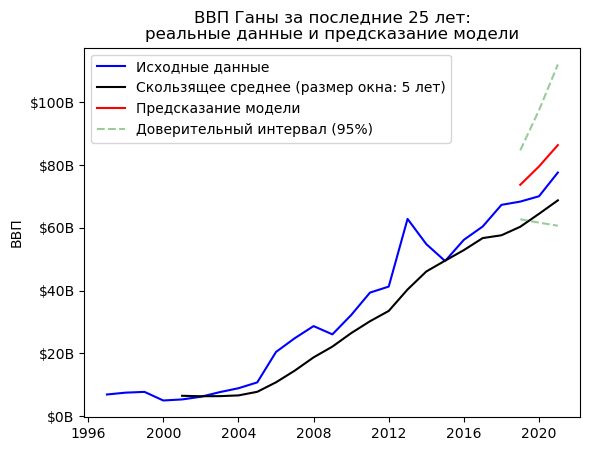

In [23]:
from matplotlib.ticker import FuncFormatter

last_25_years = df.iloc[-25:]
q = 5
rolling_mean = last_25_years[gpd_column_name].rolling(window=q).mean()

fig, ax = plt.subplots()

plt.rcParams["figure.figsize"] = 10, 6

plt.plot(last_25_years[gpd_column_name], label='Исходные данные', color='blue')
plt.plot(rolling_mean, label=f'Скользящее среднее (размер окна: {q} лет)', color='black')

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Предсказание модели",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Доверительный интервал (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

def format_ticks(value, pos):
    return '$' + str(round(int(value) / 10**9)) + 'B'

# Create a FuncFormatter instance and set it for the y-axis
formatter = FuncFormatter(format_ticks)
ax.yaxis.set_major_formatter(formatter)

plt.title('ВВП Ганы за последние 25 лет:\nреальные данные и предсказание модели')
plt.xlabel('')
plt.ylabel('ВВП')
plt.legend()


plt.show()

#### Задание 1.6

Сделайте выводы по полученным результатам

##### Вывод

Наша модель оказалась слишком оптимистичной. Можно сказать, она предсказала самый позитивный сценарий роста ВВП Ганы. Но не смотря на то, что предсказание оказалось не очень точным, все-таки доверительные реальные данные попали в доверительный интервал.

#### Задание 2.1

Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода `DataFrame.asfreq()`, передав в него параметр частоты, например `'d'` — день, `'m'` — месяц. 

In [24]:
df_resampled = df.asfreq('AS')

missing_dates = df_resampled[df_resampled[gpd_column_name].isnull()]

if len(missing_dates) > 0:
    print(f'Пропущенные даты:\n{missing_dates}')
else:
    print('Пропусков в датах не обнаружено.')

Пропусков в датах не обнаружено.


#### Задание 2.2

Проверьте данные на наличие пропущенных значений.

In [25]:
missing_values_sum = df[gpd_column_name].isna().sum()

if missing_values_sum > 0:
    print(f'Пропущенных значений: {missing_values_sum}')
else:
    print('Пропущенных значений не обнаружено.')

Пропущенных значений не обнаружено.


#### Задание 2.3

Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`

In [26]:
m = df[gpd_column_name] == 0

df.loc[m, gpd_column_name] = np.nan

#### Задание 2.4

Для заполнения пропусков выполните интерполяцию.

In [27]:
df.interpolate('linear', inplace=True)

#### Задание 2.5

Проверьте полученный ряд на стационарность, определите параметры модели (`ARIMA`/`ARMA`) и запустите модель.

In [28]:
# От того, что мы улучшили одно значение (заменили ноль 
# на интерполированное значение) параметры временного ряда
# вряд ли сильно изменятся. Но все же удостоверимся в этом.

run_adfuller_on_data(df)

df_diff_1 = df.diff().dropna()
run_adfuller_on_data(df_diff_1)

df_diff_2 = df_diff_1.diff().dropna()
run_adfuller_on_data(df_diff_2)

df_diff_3 = df_diff_2.diff().dropna()
run_adfuller_on_data(df_diff_3)

ADF Statistic: 2.380848757555632
p-value: 0.99900101016983
Critical Values:
	1%: -3.542
	5%: -2.910
	10%: -2.593
ADF Statistic: -1.739718489292148
p-value: 0.41077316906677686
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
ADF Statistic: -1.7042548913504132
p-value: 0.4289215730117656
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599
ADF Statistic: -5.45620862982844
p-value: 2.5783244972044193e-06
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


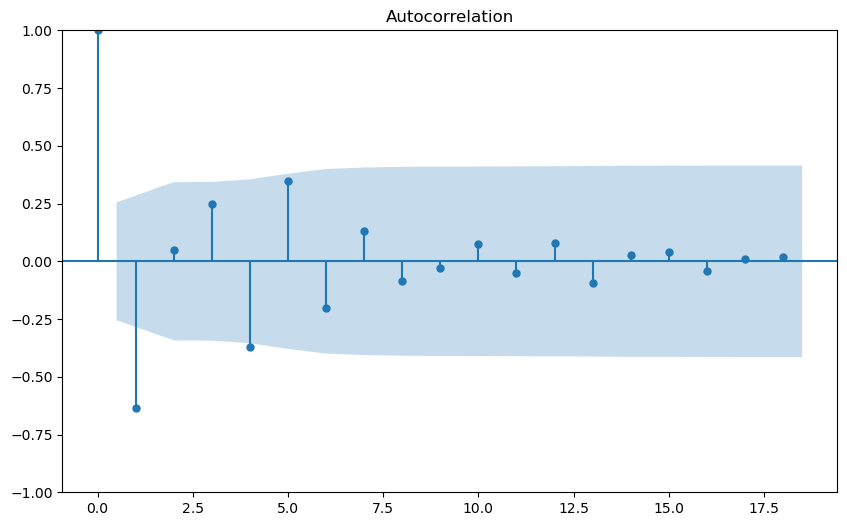

In [29]:
# Видим, что порядок дифференцирования остался прежним d=3
# Проверим p и q

plot_acf(df_diff_3)
plt.show()

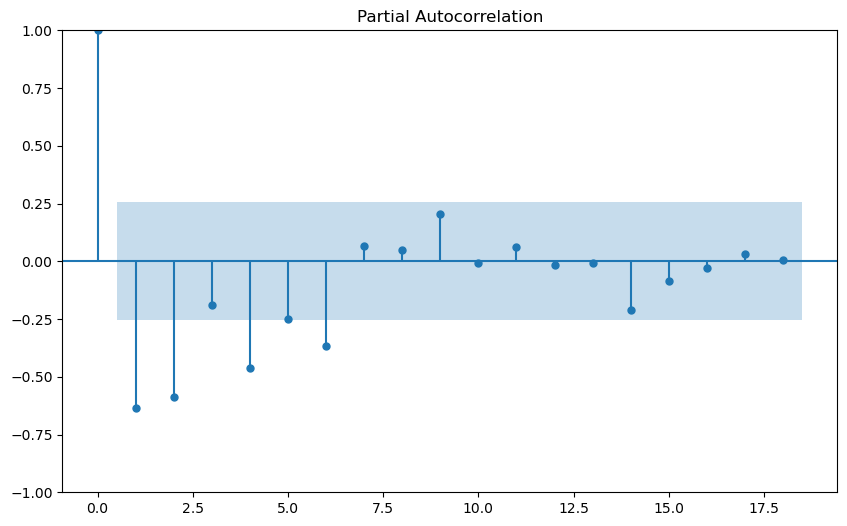

In [30]:
# Видим, что по-прежнему q=1

plot_pacf(df_diff_3)
plt.show()

In [31]:
# Видим, что по-прежнему p=2

# Заново делим данные на train и test
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

# Создаем и обучаем нашу модель
p = 2
d = 3
q = 1
arima_model = ARIMA(train_df, order=(p, d, q)).fit()
start = start=test_df.index[0]
end = test_df.index[-1]
test_pred = arima_model.predict(start=start, end=end, dynamic=False)

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Wed, 18 Oct 2023   AIC                           2659.226
Time:                        21:00:21   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.0

/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/ev/miniconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


#### Задание 2.6

Изменился ли `AIC` критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

##### Вывод

Мы видим, что изменение в данных, которое мы произвели, практически никак не повлияло на результат. Предыдущая и нынешняя модели имеют `AIC` равный `2659.231` и `2659.226` соответвенно. Последний результат немного лучше, но это ничтожное улучшение.

В принципе, это было ожидаемо, потому что с помощью интерполяции мы изменили лишь одно значение, причем где-то в самом начале наблюдаемого периода, где ВВП почти не изменялся.

#### Задание 3.1

Посчитайте волатильность для вашего временного ряда.

In [32]:
df['vol'] = df[gpd_column_name].pct_change(1).mul(100).abs()
df.head()

,GDP (current US$),vol
year,,
1960-01-01,1.217087e+09,NaN
1961-01-01,1.299720e+09,6.789413
1962-01-01,1.382353e+09,6.357759
1963-01-01,1.540616e+09,11.448835
1964-01-01,1.731092e+09,12.363636


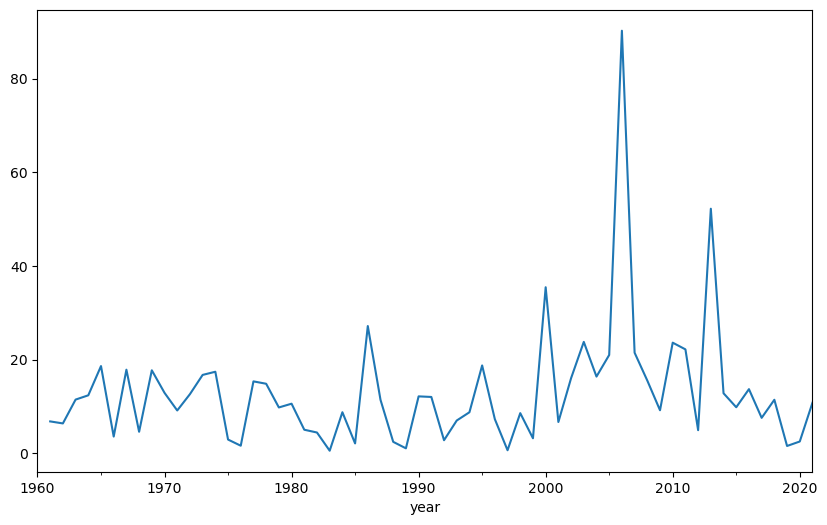

In [33]:
# отобразим волатильность
df['vol'].plot()
plt.show()

#### Задание 3.2

Используйте GARCH-модель для предсказания волатильности.

In [41]:
# разобъем выборку на две, тренировочную и тестовую
train_df = df.iloc[:-3]
test_df = df.iloc[-3:]

# проверим, является ли ряд стационарным
run_adfuller_on_data(train_df['vol'][1:])


ADF Statistic: -6.725311059553779
p-value: 3.4014596148856493e-09
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595


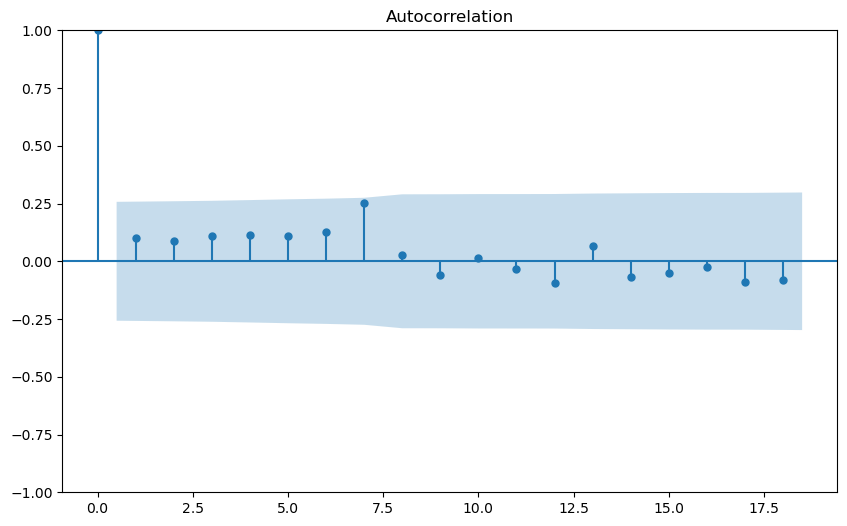

In [35]:
# видим, что ряд является стационарным

# чтобы определить q построим график автокорреляции

plot_acf(train_df['vol'][1:])
plt.show()

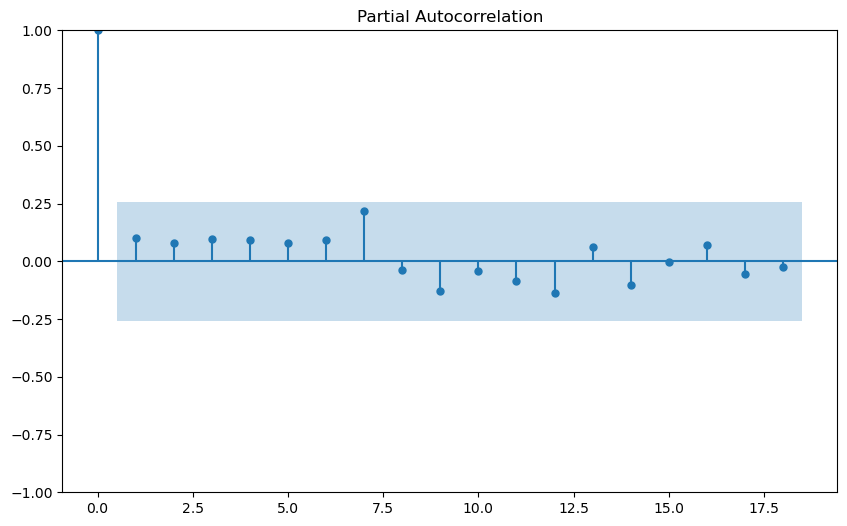

In [36]:
# самый большой лаг — седьмой, значит q = 7

# чтобы определить p построим график частичной автокорреляции

plot_pacf(train_df['vol'][1:])
plt.show()

In [42]:
df['vol'].loc[df.index]

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
                ...    
2017-01-01     7.551317
2018-01-01    11.410877
2019-01-01     1.542746
2020-01-01     2.495937
2021-01-01    10.780603
Name: vol, Length: 62, dtype: float64

In [37]:
# самый большой лаг — седьмой, значит p = 7

# прежде чем строить модель проведем некоторые преобразования

# нам важно сохранить объем датасета, поэтому берем за исходные данныеё
# весь датасет с индексами, который содержит и train и test часть
garch_df = pd.DataFrame(df['vol'].loc[df.index])

# далее необходимо использовать актуальные обучающие данные, которые
# находятся в выборке train_df. Мы никак не преобразовывали нашу обучющую 
# выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, 
# например скользящее среднее для сглаживания, то необходимо передать 
# измененный train_df датасет.
garch_df.loc[train_df.index, 'vol'] = train_df['vol'].dropna()

# pip install arch
from arch import arch_model

# строим две модели, ARCH и GARCh
model_arch = arch_model(garch_df['vol'].dropna(), p=7, q=7)
model_garch = arch_model(garch_df['vol'].dropna(), p=7, q=7, vol='GARCH')

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки
model_arch_results = model_arch.fit(last_obs=test_df.index[0])
model_garch_results = model_garch.fit(last_obs=test_df.index[0])

Iteration:      1,   Func. Count:     18,   Neg. LLF: 230.8741756793048
Iteration:      2,   Func. Count:     39,   Neg. LLF: 218.31779246062197
Iteration:      3,   Func. Count:     56,   Neg. LLF: 216.0099604333599
Iteration:      4,   Func. Count:     73,   Neg. LLF: 221.19321252771397
Iteration:      5,   Func. Count:     91,   Neg. LLF: 234.3804789604316
Iteration:      6,   Func. Count:    110,   Neg. LLF: 216.30191431701536
Iteration:      7,   Func. Count:    128,   Neg. LLF: 214.87883791344603
Iteration:      8,   Func. Count:    145,   Neg. LLF: 214.73244202669193
Iteration:      9,   Func. Count:    162,   Neg. LLF: 214.616577595434
Iteration:     10,   Func. Count:    179,   Neg. LLF: 214.61759309068822
Iteration:     11,   Func. Count:    197,   Neg. LLF: 214.6005282438456
Iteration:     12,   Func. Count:    214,   Neg. LLF: 214.5842841439691
Iteration:     13,   Func. Count:    231,   Neg. LLF: 214.52525076137974
Iteration:     14,   Func. Count:    248,   Neg. LLF: 214.

In [38]:
# прогнозируем волатильность

pred_df = pd.DataFrame(index=df.index)

pred_df['arch_preds'] = model_arch_results.forecast().residual_variance.loc[test_df.index]
pred_df['garch_preds'] = model_garch_results.forecast().residual_variance.loc[test_df.index]

#### Задание 3.3

Используйте линейную регрессию для получения прогноза.

In [39]:
from sklearn import linear_model

X_train = pd.DataFrame(range(df['vol'].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df['vol'].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df['vol'].fillna(0)
y_test = test_df['vol'].fillna(0)


lr_model = linear_model.LinearRegression()

lr_model.fit(X_train, y_train)

lr_predict = lr_model.predict(X_test)


#### Задание 3.4

Визуализируйте полученное предсказание вместе с фактическим значением.

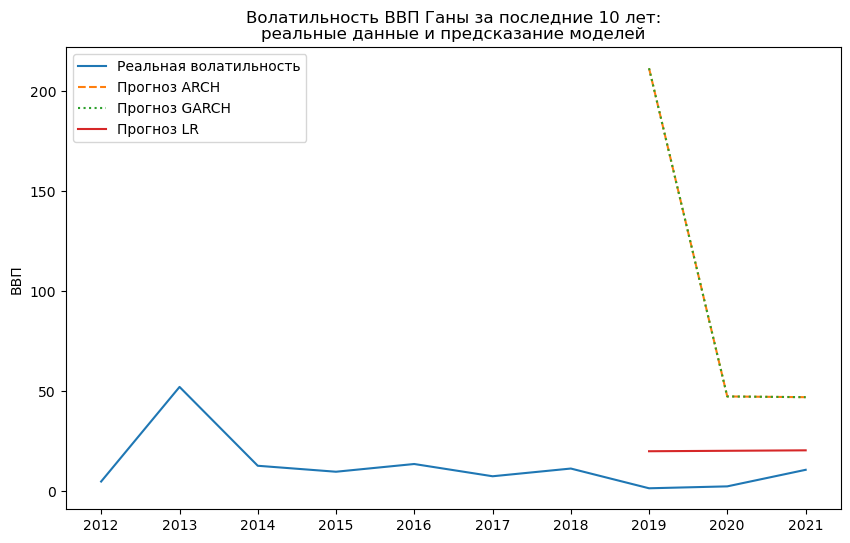

In [40]:

last_10_years = df.iloc[-10:]

plt.plot(last_10_years['vol'], label='Реальная волатильность')
plt.plot(pred_df['arch_preds'], label='Прогноз ARCH', linestyle='--')
plt.plot(pred_df['garch_preds'], label='Прогноз GARCH', linestyle=':')
plt.plot(pd.Series(lr_predict, index=y_test.index), label='Прогноз LR')

plt.title('Волатильность ВВП Ганы за последние 10 лет:\nреальные данные и предсказание моделей')
plt.xlabel('')
plt.ylabel('ВВП')
plt.legend()

plt.show()

#### Задание 3.5

Сравните результаты и сделайте выводы.

##### Вывод

Обе модели ARCH и GARCH показали одинаковые результаты. Но эти результаты оказались совершенно далеки от реальности. Модель линейной регрессии сделала более точное предсказание. Хотя должно было быть наоборот. Видимо мы что-то сделали неправильно.

#### Задание 3.6

Почему результат модели GARCH получился именно таким?

В том и дело, что ничего у нас не получилось. Непростая это тема, нужно разбираться, а времени нет...